In [3]:
# TODO: This needs to be updated to use mutation AA positions rather than residue position (check for how Crr did this)
from biopandas.pdb import PandasPdb
# pdf = PandasPdb().read_pdb('/home/pphaneuf/iML1515_GP/iML1515_GP/genes/b3926/b3926_protein/structures/GLPK_ECOLI_model1_clean.pdb')
pdf = PandasPdb().read_pdb('../data/pdb_files/GlpK_single_mol_mutfunc.pdb')  # 3EZW, but only monomer
adf = pdf.df['ATOM']
cadf = adf[adf["atom_name"]=="CA"]
cadf = cadf.set_index("residue_number")
cadf = cadf[cadf["alt_loc"].isin(['A', ''])]  # removing the 'B' residue alternative locations. I could also find the average between the two positions if necessary to account for both.
cadf.head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,insertion,blank_3,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
residue_number,,,,,,,,,,,,,,,,,,,,
1,ATOM,11816,,CA,,THR,,A,,,47.187,47.310,173.622,1.0,47.43,,,C,NaN,1
2,ATOM,11823,,CA,,GLU,,A,,,45.068,49.437,171.345,1.0,42.87,,,C,NaN,8
3,ATOM,11832,,CA,,LYS,,A,,,42.263,47.325,169.893,1.0,37.81,,,C,NaN,17
4,ATOM,11841,,CA,,LYS,,A,,,42.412,48.516,166.362,1.0,32.49,,,C,NaN,26
5,ATOM,11850,,CA,,TYR,,A,,,40.635,45.768,164.465,1.0,26.34,,,C,NaN,35


In [4]:
import pandas as pd

aa_mut_cnt_df = pd.read_csv("./glpK_pub_aa_muts.csv")
aa_mut_cnt_df.head()

,AA position,mutation type,disrupt coding seq,disrupt func,disrupt struct,study,study color,mutation count,name,color
0,17,SNP,0,0,0,GYD,#AEC7E8,1,SNP AA 17,#ABABAB
1,34,SNP,0,0,0,GYD,#AEC7E8,2,SNP AA 34,#ABABAB
2,54,SNP,0,0,0,GYD,#AEC7E8,1,SNP AA 54,#ABABAB
3,55,SNP,0,0,0,GYD,#AEC7E8,1,SNP AA 55,#ABABAB
4,56,SNP,0,0,0,GYD,#AEC7E8,1,SNP AA 56,#ABABAB


In [5]:
gff_df = pd.read_csv("./glpK_pub_aa_feats.csv")
gff_df = gff_df[~(gff_df.feature.isin(["Turn", "Helix", "Beta strand", "Carbohydrate kinase N-terminal PFAM domain", "Carbohydrate kinase C-terminal PFAM domain"]))].copy()
gff_df.head()

,seqname,source,feature,start,end,score,strand,frame,attribute,9,color
0,P0A6F3,UniProtKB,Chain,2,502,.,.,.,ID=PRO_0000059451;Note=Glycerol kinase,NaN,white
1,P0A6F3,UniProtKB,ATP binding site,14,16,.,.,.,Note=ATP,NaN,#FFC125
2,P0A6F3,UniProtKB,ATP binding site,412,416,.,.,.,Note=ATP,NaN,#FFC125
3,P0A6F3,UniProtKB,Substrate binding site,84,85,.,.,.,Note=Substrate binding,NaN,#911EB4
4,P0A6F3,UniProtKB,Allosteric FBP inhibitor binding site,234,236,.,.,.,Note=Allosteric FBP inhibitor binding,NaN,#76EE00


In [6]:
aa_mut_cnt_df = aa_mut_cnt_df[~(aa_mut_cnt_df["mutation type"].str.contains("MOB"))].copy()  # Currently doesn't hurt to include MOB insertion pos for EIIAglc
dist_aa_df = aa_mut_cnt_df.copy()

# don't care about about multiple muts on same AA for now
# dist_aa_df = dist_aa_df.drop(columns=["mutation type", "mutation count", "disrupt coding seq", "disrupt func", "disrupt struct", "color", "study", "study color"])
dist_aa_df = dist_aa_df[["AA position", "name"]]
dist_aa_df = dist_aa_df.drop_duplicates()

for _, r in gff_df.iterrows():
    if r["feature"] != "Chain":
        for aa in range(r["start"], r["end"] + 1): 
            dist_aa_df = dist_aa_df.append({"AA position":aa, "name": r["feature"] + " AA " + str(aa)}, ignore_index=True)

dist_aa_df["AA position"] = dist_aa_df["AA position"].astype(int)
dist_aa_df["residue index"] = dist_aa_df["AA position"] - 1  # this really depends on the structure being used. Before copy-pasting, double check if the initiator methionine is included in structure.

dist_aa_df['coords'] = dist_aa_df.apply(lambda r:
                                        [
                                            cadf.at[r["residue index"], "x_coord"],
                                            cadf.at[r["residue index"], "y_coord"],
                                            cadf.at[r["residue index"], "z_coord"],
                                        ],
                                        axis=1)
dist_aa_df.head()

,AA position,name,residue index,coords
0,17,SNP AA 17,16,"[35.235, 29.092, 155.882]"
1,34,SNP AA 34,33,"[39.499, 27.607, 153.412]"
2,54,SNP AA 54,53,"[35.204, 23.969, 163.084]"
3,55,SNP AA 55,54,"[38.733, 23.143, 162.023]"
4,56,SNP AA 56,55,"[38.588, 25.29, 158.87]"


In [7]:
import numpy as np
def _get_dist_mat_label(r):
    lbl = r["name"]
    if ("SNP" in r["name"]) or ("INS" in r["name"]):
        lbl = "mut AA " + str(r["AA position"])
    return lbl
        

dist_aa_df['dist mat label'] = dist_aa_df.apply(lambda r: _get_dist_mat_label(r), axis=1)
# dist_aa_df = dist_aa_df.set_index("AA position")
dist_aa_df = dist_aa_df.set_index("dist mat label")

dist_aa_df.head()

,AA position,name,residue index,coords
dist mat label,,,,
mut AA 17,17,SNP AA 17,16,"[35.235, 29.092, 155.882]"
mut AA 34,34,SNP AA 34,33,"[39.499, 27.607, 153.412]"
mut AA 54,54,SNP AA 54,53,"[35.204, 23.969, 163.084]"
mut AA 55,55,SNP AA 55,54,"[38.733, 23.143, 162.023]"
mut AA 56,56,SNP AA 56,55,"[38.588, 25.29, 158.87]"


In [8]:
import numpy as np


def get_AA_dist(aa1, aa2):
    AA_dist = np.nan
    aa1_coords = dist_aa_df.at[aa1, "coords"]
    aa2_coords = dist_aa_df.at[aa2, "coords"]   
    AA_dist = np.sqrt((aa2_coords[0] - aa1_coords[0])**2
                      + (aa2_coords[1] - aa1_coords[1])**2
                      + (aa2_coords[2] - aa1_coords[2])**2)
    return AA_dist


dist_mat = pd.DataFrame(np.nan, columns=dist_aa_df.index, index=dist_aa_df.index)
for ir in dist_mat.index:
    for ic in dist_mat.columns:
        dist_mat.at[ir, ic] = get_AA_dist(ir, ic)
dist_mat.head()

dist mat label,mut AA 17,mut AA 34,mut AA 54,mut AA 55,mut AA 56,mut AA 59,mut AA 63,mut AA 65,mut AA 66,mut AA 73,...,Crr interface AA 473,Crr interface AA 474,Crr interface AA 475,Crr interface AA 476,Crr interface AA 477,Crr interface AA 478,Crr interface AA 479,Crr interface AA 480,Crr interface AA 481,Crr interface AA 482
dist mat label,,,,,,,,,,,,,,,,,,,,,
mut AA 17,0.000000,5.146632,8.838263,9.237883,5.884382,9.022225,11.621978,14.732942,16.375217,22.733958,...,36.578678,38.928012,40.695530,43.055563,42.781488,45.009908,43.049807,39.566181,41.064888,42.800583
mut AA 34,5.146632,0.000000,11.190606,9.729510,5.999014,8.317638,9.937535,14.334724,14.830531,23.970921,...,38.295253,40.262348,42.162812,44.847622,44.913394,46.962723,44.677409,41.397643,43.165022,44.586430
mut AA 54,8.838263,11.190606,0.000000,3.776485,5.563658,8.335402,14.059296,17.180792,18.329016,22.258637,...,44.445387,47.001660,48.543966,50.620616,49.953100,52.163320,50.437302,46.829703,47.899258,49.705749
mut AA 55,9.237883,9.729510,3.776485,0.000000,3.817335,5.939303,11.971413,15.897105,16.299843,22.065821,...,45.767736,48.132458,49.812959,52.110492,51.674368,53.825278,51.895096,48.382890,49.658971,51.313318
mut AA 56,5.884382,5.999014,5.563658,3.817335,0.000000,5.098327,10.168044,14.386746,15.006110,22.030819,...,42.400205,44.669594,46.430327,48.840600,48.559411,50.705403,48.678099,45.222121,46.661979,48.275891


In [9]:
df = gff_df[["feature", "color"]].drop_duplicates()
feat_to_color_d = dict()
for _, r in df.iterrows():
    feat_to_color_d[r["feature"]] = r["color"]
feat_to_color_d

{'Chain': 'white',
 'ATP binding site': '#FFC125',
 'Substrate binding site': '#911EB4',
 'Allosteric FBP inhibitor binding site': '#76EE00',
 'Crr and Zinc binding site': '#42D4F4',
 'N6-malonyllysine site': '#2AB0C1',
 'GlpK subunit binding site': '#B33E52',
 'GlpK subunit interface': '#4169E1',
 'Crr interface': '#FCAD74'}

In [10]:
# Adjustment so I can use the mutation needle plot legend
feat_to_color_d['ATP binding site'] = "#FFC125"
feat_to_color_d['Substrate binding site'] = "#911EB4"
feat_to_color_d['Allosteric FBP inhibitor binding site'] = "#76EE00"
feat_to_color_d['EIIA and Zinc binding site'] = "#42D4F4"
feat_to_color_d['N6-malonyllysine site'] = "#FA8072"
feat_to_color_d['GlpK subunit binding site'] = "#B33E52"
feat_to_color_d['GlpK subunit interface'] = "#4169E1"
feat_to_color_d['EIIA interface'] = "#D67195"

In [11]:
# import seaborn as sns
# import matplotlib
# import matplotlib.pyplot as mpl
# %matplotlib inline
# mpl.rcParams["figure.dpi"] = 100
# mpl.rcParams['font.sans-serif'] = ["FreeSans"]
# sns.set_context("paper")
# sns.set_style("white")
# sns.set(font="FreeSans")
 
# labels = ['Label 1', 'Label 2', 'Label 3', 'Label 4']
# colors = []


# fig = mpl.figure(figsize=(2, 1.25))
# # ax = fig.add_subplot(111)
# patches = [
#     mpatches.Patch(color=color, label=label)
#     for label, color in zip(labels, colors)]
# fig.legend(patches, labels, loc='center', frameon=False)
# plt.show()

In [12]:
AA_feat_dist_df = dist_mat[dist_mat.index.str.contains("mut")]
AA_feat_dist_df = AA_feat_dist_df.T
AA_feat_dist_df = AA_feat_dist_df[~(AA_feat_dist_df.index.str.contains("mut"))]

col_colors = []
for _, r in AA_feat_dist_df.iterrows():
    col_colors.append(feat_to_color_d[r.name[:r.name.find(" AA")]])
# col_colors

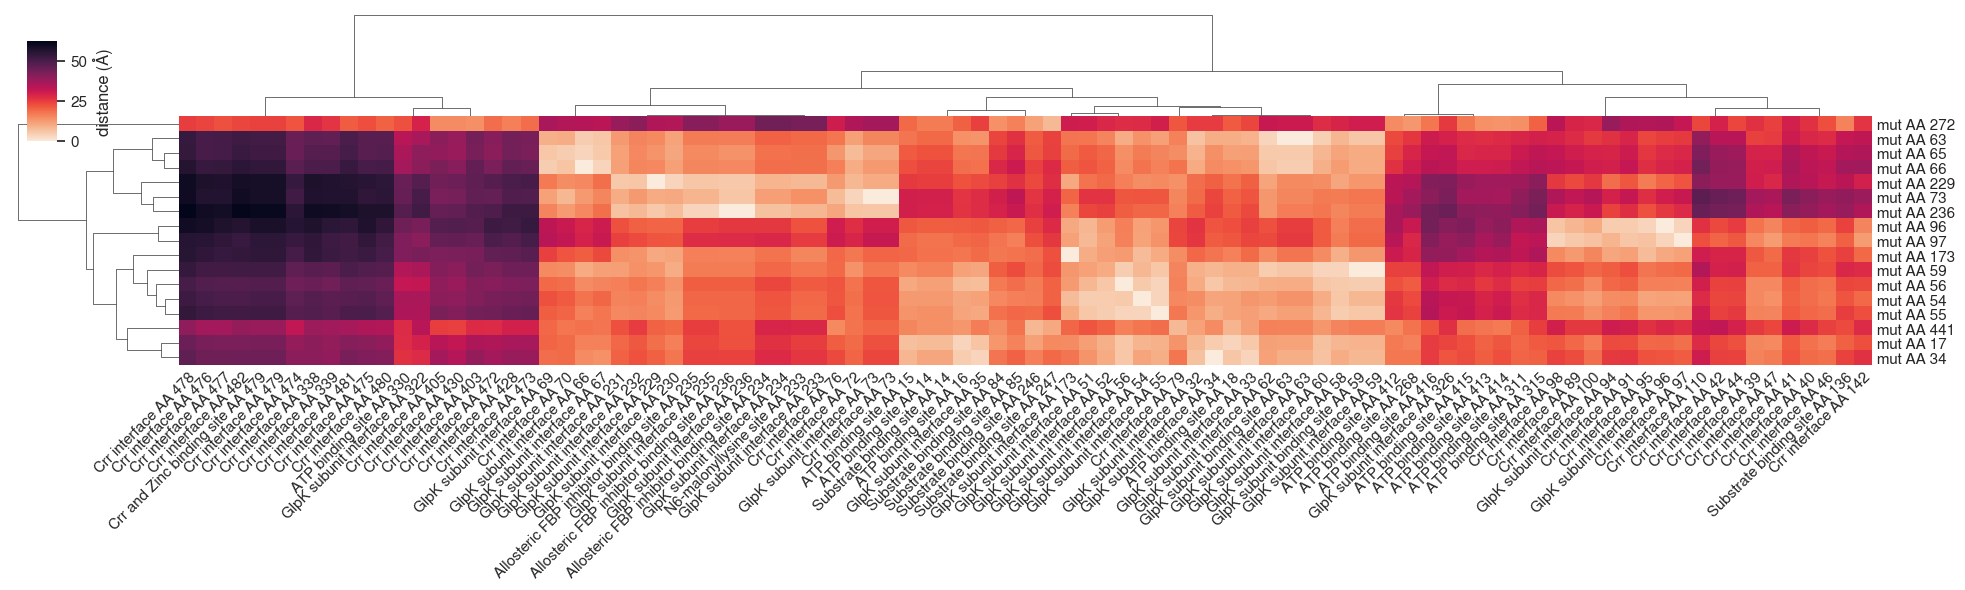

In [13]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as mpl
%matplotlib inline
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams['font.sans-serif'] = ["FreeSans"]
sns.set_context("paper")
sns.set_style("white")
sns.set(font="FreeSans")

df = AA_feat_dist_df.T
cm = sns.clustermap(
    df,
#     linewidths=0.1,
    cbar_kws={'label': 'distance (Å)'},
    cbar_pos=(0.05, 0.85, 0.03, 0.10),
    yticklabels=True,
    xticklabels=True,
#     annot=True,
    cmap="rocket_r",
    col_colors=col_colors,
#     figsize=(10,10)
)
# Fix for recent matplotlib/seaborn issue
cm.ax_heatmap.set_ylim(len(df)+0, -0)

# Below is for adjusting the sizes of the dendograms and heatmaps
H = 0.5
W = 2.5
y0_offset = 0.29
x0_offset = 0.01
hm = cm.ax_heatmap.get_position()
# mpl.setp(cm.ax_heatmap.yaxis.get_majorticklabels(),fontsize=6)
# mpl.setp(cm.ax_heatmap.xaxis.get_majorticklabels(),fontsize=6)
col_dendo = cm.ax_col_dendrogram.get_position()
cm.ax_col_dendrogram.set_position([
    col_dendo.x0 + x0_offset,
    col_dendo.y0,
    col_dendo.width*W,
    col_dendo.height*1
])
row_dendo = cm.ax_row_dendrogram.get_position()
cm.ax_row_dendrogram.set_position([
    row_dendo.x0 + 0.015,
    row_dendo.y0 + y0_offset,
    row_dendo.width*1,
    row_dendo.height*H
])
cm.ax_heatmap.set_position([
    hm.x0 + x0_offset,
    hm.y0 + y0_offset,
    hm.width*W,
    hm.height*H
])
col_color_pos = cm.ax_col_colors.get_position()
cm.ax_col_colors.set_position([
    col_color_pos.x0 + 0.01,
    col_color_pos.y0 + 0.01,
    col_color_pos.width*W,
    col_color_pos.height*H
])

mpl.setp(cm.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
cm.ax_heatmap.set_ylabel('')
cm.ax_heatmap.set_xlabel('')
cm.ax_heatmap.tick_params(axis='both', which='both', length=0)
# cm.fig.suptitle("3D distance between mutated AA and small active sites on GlpK", y=0.92, x=0.6)

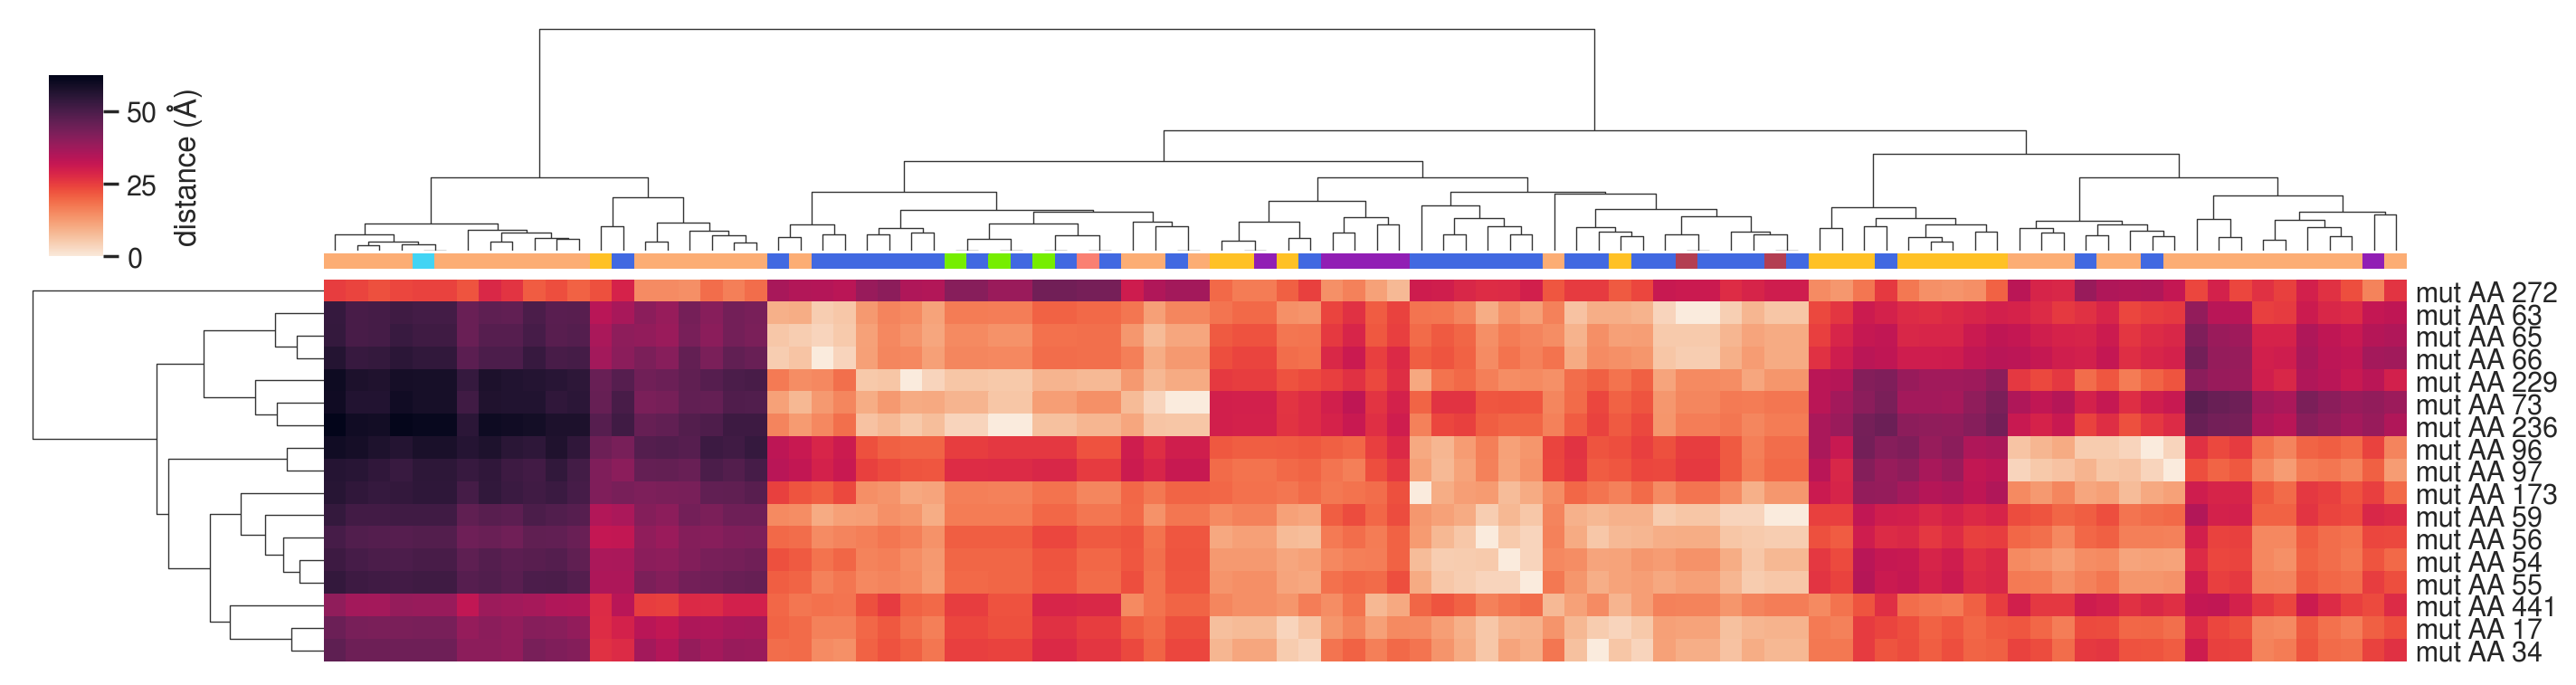

In [14]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as mpl
%matplotlib inline
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams['font.sans-serif'] = ["FreeSans"]
sns.set_context("paper")
sns.set_style("white")
sns.set(font="FreeSans")

df = AA_feat_dist_df.T
cm = sns.clustermap(
    df,
#     linewidths=0.1,
    cbar_kws={'label': 'distance (Å)'},
    cbar_pos=(0.05, 0.85, 0.03, 0.10),
    yticklabels=True,
    xticklabels=True,
#     annot=True,
    cmap="rocket_r",
    col_colors=col_colors,
#     figsize=(10,10)
)
# Fix for recent matplotlib/seaborn issue
cm.ax_heatmap.set_ylim(len(df)+0, -0)

# Below is for adjusting the sizes of the dendograms and heatmaps
H = 0.425
W = 1.7
y0_offset = 0.29
x0_offset = 0.01
hm = cm.ax_heatmap.get_position()
# mpl.setp(cm.ax_heatmap.yaxis.get_majorticklabels(),fontsize=6)
# mpl.setp(cm.ax_heatmap.xaxis.get_majorticklabels(),fontsize=6)
col_dendo = cm.ax_col_dendrogram.get_position()
cm.ax_col_dendrogram.set_position([
    col_dendo.x0 + x0_offset,
    col_dendo.y0,
    col_dendo.width*W,
    col_dendo.height*1
])
row_dendo = cm.ax_row_dendrogram.get_position()
cm.ax_row_dendrogram.set_position([
    row_dendo.x0 + 0.015,
    row_dendo.y0 + y0_offset,
    row_dendo.width*1,
    row_dendo.height*H
])
cm.ax_heatmap.set_position([
    hm.x0 + x0_offset,
    hm.y0 + y0_offset,
    hm.width*W,
    hm.height*H
])
col_color_pos = cm.ax_col_colors.get_position()
cm.ax_col_colors.set_position([
    col_color_pos.x0 + 0.01,
    col_color_pos.y0 + 0.01,
    col_color_pos.width*W,
    col_color_pos.height*H
])

# mpl.setp(cm.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
cm.ax_heatmap.set_ylabel('')
cm.ax_heatmap.set_xlabel('')
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.tick_params(axis='both', which='both', length=0)
# cm.fig.suptitle("3D distance between mutated AA and small active sites on GlpK", y=0.92, x=0.6)

In [15]:
mut_aa_feat_prox_df = pd.DataFrame()
df = AA_feat_dist_df.T
for mut_aa, r in df.iterrows():
    min_dist_feats = r[r==r.min()]
    for feat_AA, min_dist in min_dist_feats.iteritems():
        feat = feat_AA[:feat_AA.find(" AA ")]
        mut_aa_feat_prox_df = mut_aa_feat_prox_df.append({"mut AA": mut_aa.replace("mut AA ", ''), "nearest feature": feat}, ignore_index=True)
mut_aa_feat_prox_df

mut_aa_feat_prox_df.to_pickle("./mut_aa_feat_prox_df.pkl")

In [16]:
mut_aa_feat_prox_df

,mut AA,nearest feature
0,17,ATP binding site
1,34,GlpK subunit interface
2,54,GlpK subunit interface
3,55,GlpK subunit interface
4,56,GlpK subunit interface
5,59,GlpK subunit binding site
6,59,GlpK subunit interface
7,63,GlpK subunit binding site
8,63,GlpK subunit interface
9,65,GlpK subunit interface


In [17]:
gly_glpK_mut_df = pd.read_pickle("./gly_glpK_mut_df.pkl")
gly_glpK_mut_df.head()

,COG links,COGs,Details,EC number links,EC numbers,Mutation Type,Position,RBS,Reference Seq,Sequence Change,...,tech_rep,temperature,terminator,mutation size,truncation,AA range,subgenic features,AA change,conservation (SIFT),stability (ΔΔGpred)
0,{'Energy production and conversion': ['ECK1200...,[{'name': 'Energy production and conversion'}],S59Y (TCC→TAC),{'2.7.1.30': ['ECK120014723']},"[{'name': '2.7.1.30', 'significantly associate...",SNP,4117047.0,{},NC_000913,G→T,...,1.0,30 celsius,{},1,False,"(59, 59)","{Carbohydrate kinase N-terminal PFAM domain, G...",S59Y,True,False
1,{'Energy production and conversion': ['ECK1200...,[{'name': 'Energy production and conversion'}],N229H (AAC→CAC),{'2.7.1.30': ['ECK120014723']},"[{'name': '2.7.1.30', 'significantly associate...",SNP,4116538.0,{},NC_000913,T→G,...,1.0,30 celsius,{},1,False,"(229, 229)","{Carbohydrate kinase N-terminal PFAM domain, G...",N229H,False,False
2,{'Energy production and conversion': ['ECK1200...,[{'name': 'Energy production and conversion'}],W54L (TGG→TTG),{'2.7.1.30': ['ECK120014723']},"[{'name': '2.7.1.30', 'significantly associate...",SNP,4117062.0,{},NC_000913,C→A,...,1.0,30 celsius,{},1,False,"(54, 54)","{Carbohydrate kinase N-terminal PFAM domain, G...",W54L,False,False
3,{'Energy production and conversion': ['ECK1200...,[{'name': 'Energy production and conversion'}],T56A (ACC→GCC),{'2.7.1.30': ['ECK120014723']},"[{'name': '2.7.1.30', 'significantly associate...",SNP,4117057.0,{},NC_000913,T→C,...,1.0,30 celsius,{},1,False,"(56, 56)","{Carbohydrate kinase N-terminal PFAM domain, G...",T56A,False,False
4,{'Energy production and conversion': ['ECK1200...,[{'name': 'Energy production and conversion'}],S59Y (TCC→TAC),{'2.7.1.30': ['ECK120014723']},"[{'name': '2.7.1.30', 'significantly associate...",SNP,4117047.0,{},NC_000913,G→T,...,1.0,30 celsius,{},1,False,"(59, 59)","{Carbohydrate kinase N-terminal PFAM domain, G...",S59Y,True,False


In [18]:
mut_aa_feat_prox_df = mut_aa_feat_prox_df.set_index("mut AA")
mut_aa_feat_prox_df

,nearest feature
mut AA,
17,ATP binding site
34,GlpK subunit interface
54,GlpK subunit interface
55,GlpK subunit interface
56,GlpK subunit interface
59,GlpK subunit binding site
59,GlpK subunit interface
63,GlpK subunit binding site
63,GlpK subunit interface


In [19]:
aa_mut_effect_df = pd.DataFrame(columns=["mutated AA", "functionally disruptive", "structurally disruptive", "nearest feature"])
for _, m in gly_glpK_mut_df.iterrows():
    if m["AA range"][0] == m["AA range"][1]:
        aa = m["AA range"][0]
        for _, r in mut_aa_feat_prox_df[mut_aa_feat_prox_df.index==str(aa)].iterrows():
            aa_mut_effect_df = aa_mut_effect_df.append({
                "mutated AA": aa,
                "functionally disruptive": m["conservation (SIFT)"],
                "structurally disruptive": m["stability (ΔΔGpred)"],
                "nearest feature": r["nearest feature"]},
                ignore_index=True)
    else:
        for aa in m["AA range"]:
            for _, r in mut_aa_feat_prox_df[mut_aa_feat_prox_df.index==str(aa)].iterrows():
                aa_mut_effect_df = aa_mut_effect_df.append({
                    "mutated AA": aa,
                    "functionally disruptive": m["conservation (SIFT)"],
                    "structurally disruptive": m["stability (ΔΔGpred)"],
                    "nearest feature": r["nearest feature"]},
                    ignore_index=True)

aa_mut_effect_df["unknown"] = aa_mut_effect_df.apply(lambda r: True if ((r["functionally disruptive"]==False) & (r["structurally disruptive"]==False)) else False, axis=1)
aa_mut_effect_df.head()

,mutated AA,functionally disruptive,structurally disruptive,nearest feature,unknown
0,59,True,False,GlpK subunit binding site,False
1,59,True,False,GlpK subunit interface,False
2,229,False,False,GlpK subunit interface,True
3,54,False,False,GlpK subunit interface,True
4,56,False,False,GlpK subunit interface,True


In [20]:
# aa_mut_effect_df
from collections import Counter
d = Counter(aa_mut_effect_df["nearest feature"])

# To make it easier to turn into a DF
d2 = dict()
for k, v in d.items():
    d2[k] = [v]
cnt_df = pd.DataFrame(d2).T
cnt_df

,0
GlpK subunit binding site,5
GlpK subunit interface,28
Allosteric FBP inhibitor binding site,2
Crr interface,8
ATP binding site,1
Substrate binding site,2


Text(0.5, 1.0, 'Subunit interface regions\nhost the most mutations')

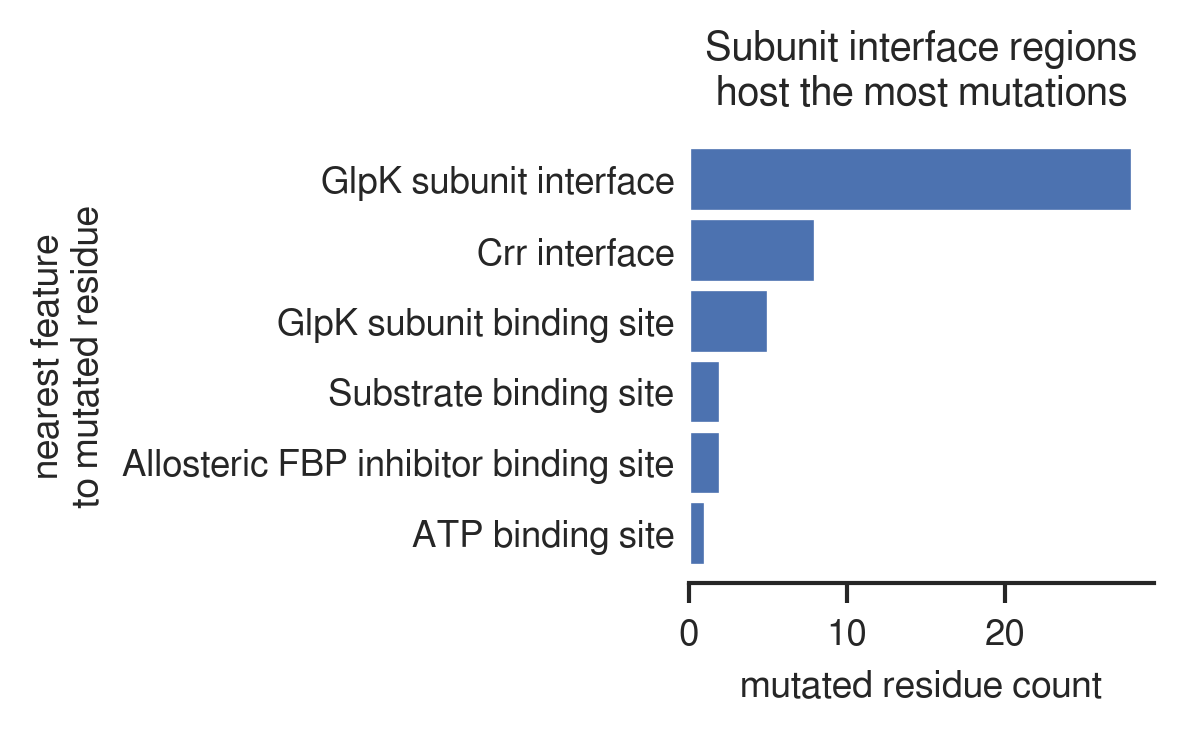

In [21]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 300
sns.set_palette("deep")
sns.set_context("paper")
sns.set_style("ticks")
plt.rcParams['font.sans-serif'] = ["FreeSans"]

df = cnt_df.copy()
df = df.sort_values(by=0)
ax = df.plot.barh(
    stacked=True,
    #     color=colors,
#     figsize=(1.5, 1.5),
    figsize=(2, 2),
    width=0.90,
)

sns.despine(ax=ax, top=True, right=True, left=True, bottom=False)
ax.get_legend().remove()
# plt.xscale('log')
ax.tick_params(axis='y', which='major', length=0)
# ax.get_xaxis().set_visible(False)

for tick in ax.get_xticklabels():
    tick.set_fontname("FreeSans")
for tick in ax.get_yticklabels():
    tick.set_fontname("FreeSans")

# df = df.reset_index()  # Resetting index for the below annotations to work
# for i, r in df.iterrows():
#     s = r[0]
#     ax.text(r[0], i-0.37, s, fontname="FreeSans", fontsize=10)


ax.tick_params(axis='y', which='both', length=0)
# ax.set_xticklabels([])
ax.set_xlabel('mutated residue count', fontname="FreeSans", fontsize=9)
# ax.xaxis.labelpad = -2
ax.set_ylabel('nearest feature\nto mutated residue', fontname="FreeSans", fontsize=9)
ax.set_title("Subunit interface regions\nhost the most mutations")

In [22]:
cnt_columns = ["unknown", "functionally disruptive", "structurally disruptive"]
feat_mut_eff_cnt_d = {f:{"functionally disruptive":0, "structurally disruptive":0, "unknown":0} for f in aa_mut_effect_df["nearest feature"].unique()}
for nf, gdf in aa_mut_effect_df.groupby("nearest feature"):
    for _, r in gdf.iterrows():
        f = r["nearest feature"]
        for c in cnt_columns:
            feat_mut_eff_cnt_d[f][c] += int(r[c])
feat_mut_eff_cnt_d

{'GlpK subunit binding site': {'functionally disruptive': 4,
  'structurally disruptive': 0,
  'unknown': 1},
 'GlpK subunit interface': {'functionally disruptive': 5,
  'structurally disruptive': 5,
  'unknown': 19},
 'Allosteric FBP inhibitor binding site': {'functionally disruptive': 0,
  'structurally disruptive': 0,
  'unknown': 2},
 'Crr interface': {'functionally disruptive': 1,
  'structurally disruptive': 5,
  'unknown': 3},
 'ATP binding site': {'functionally disruptive': 0,
  'structurally disruptive': 0,
  'unknown': 1},
 'Substrate binding site': {'functionally disruptive': 0,
  'structurally disruptive': 2,
  'unknown': 0}}

In [23]:
cnt_df = pd.DataFrame(feat_mut_eff_cnt_d).T
cnt_df["total"] = cnt_df.sum(axis=1)
cnt_df

,functionally disruptive,structurally disruptive,unknown,total
GlpK subunit binding site,4,0,1,5
GlpK subunit interface,5,5,19,29
Allosteric FBP inhibitor binding site,0,0,2,2
Crr interface,1,5,3,9
ATP binding site,0,0,1,1
Substrate binding site,0,2,0,2


In [24]:
cnt_df = cnt_df.T
cnt_df = cnt_df.rename(columns={"Allosteric FBP inhibitor binding site": "FBP inhibitor binding site"})
cnt_df = cnt_df.T
cnt_df

,functionally disruptive,structurally disruptive,unknown,total
GlpK subunit binding site,4,0,1,5
GlpK subunit interface,5,5,19,29
FBP inhibitor binding site,0,0,2,2
Crr interface,1,5,3,9
ATP binding site,0,0,1,1
Substrate binding site,0,2,0,2


In [25]:
prop_df = cnt_df.copy()
prop_df = prop_df.astype(float)
for c in prop_df.columns:
    for r in prop_df.index:
        prop_df.at[r, c] = cnt_df.at[r, c]/cnt_df.at[r, "total"]
prop_df

,functionally disruptive,structurally disruptive,unknown,total
GlpK subunit binding site,0.800000,0.000000,0.200000,1.0
GlpK subunit interface,0.172414,0.172414,0.655172,1.0
FBP inhibitor binding site,0.000000,0.000000,1.000000,1.0
Crr interface,0.111111,0.555556,0.333333,1.0
ATP binding site,0.000000,0.000000,1.000000,1.0
Substrate binding site,0.000000,1.000000,0.000000,1.0


In [26]:
prop_df = prop_df.rename(columns={
    "functionally disruptive": "deleterious (SIFT)",
    "structurally disruptive": "structurally destabilizing (ΔΔG)",
})

Text(0.5, 1.0, 'Mutations to the\nGlpK subunit binding sites\nare very specific')

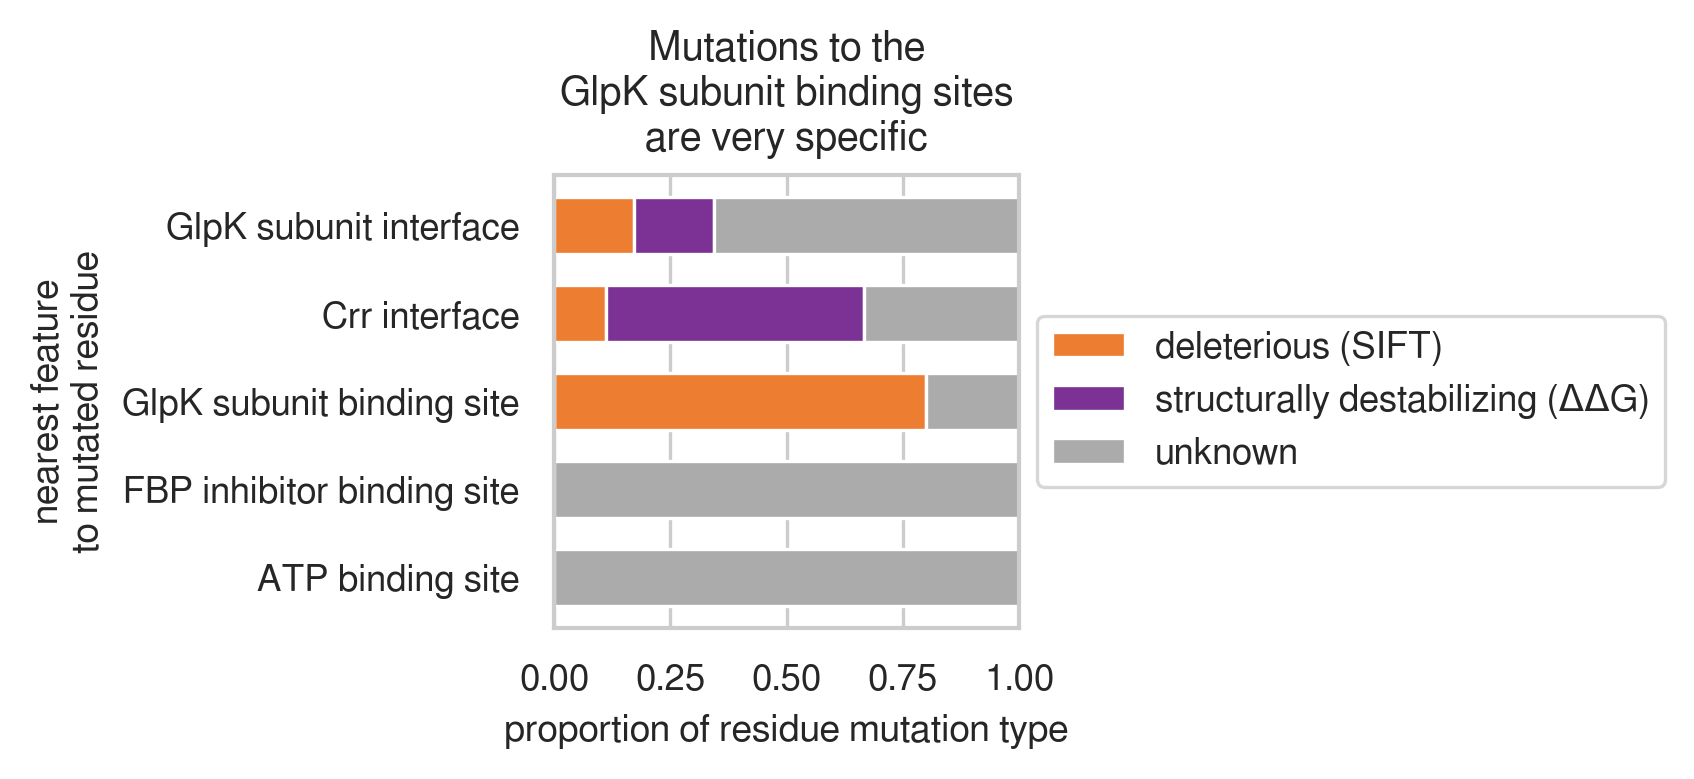

In [27]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 300
sns.set_palette("deep")
sns.set_context("paper")
# sns.set_style("ticks")
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ["FreeSans"]

df = prop_df.copy()
df = df.sort_values(by="total")
df = df.drop(columns=["total"])

# manually sorting to be the same order as the final plot in this NB
df = df.T[[
    'ATP binding site',
    'FBP inhibitor binding site',
    'GlpK subunit binding site',
    'Crr interface',
    'GlpK subunit interface',
]]
df = df.T

ax = df.plot.barh(
    color=["#ED7D31", "#7B3294", "#ABABAB"],
    figsize=(2, 2),
    width=0.65,
    stacked=True
    #     width=,
    #     figsize=(1.25, 1.25),
    #     color="#3F72B2",
)

# sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xscale('log')
# ax.tick_params(axis='y', which='major', length=0)
# ax.get_xaxis().set_visible(False)

for tick in ax.get_xticklabels():
    tick.set_fontname("FreeSans")
for tick in ax.get_yticklabels():
    tick.set_fontname("FreeSans")

# df = df.reset_index()  # Resetting index for the below annotations to work
# for i, r in df.iterrows():
#     s = str(int(r["total"]))
#     ax.text(r["total"], i-0.3,  s, fontname="FreeSans", fontsize=12)


# ax.tick_params(axis='both', which='both', length=0)
# ax.set_xticklabels([])
ax.set_xlabel('proportion of residue mutation type',
              fontname="FreeSans", fontsize=9)
ax.set_ylabel('nearest feature\nto mutated residue',
              fontname="FreeSans", fontsize=9)
# ax.xaxis.labelpad = -2
ax.set_title("")
plt.xlim(0, 1)
ax.grid(axis='y', linewidth=0)
ax.set_title("Mutations to the\nGlpK subunit binding sites\nare very specific")